# Imports and helper variables

In [11]:
import os

import numpy as np
import phoebe
from phoebe import u

import matplotlib.pyplot as plt
import scienceplots
plt.style.use("science")

from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import TimeSeries
from astropy.coordinates import EarthLocation, SkyCoord

import utils as gen_utils
from optimizers import opt_utils, dc_optimizer

import importlib
importlib.reload(gen_utils)
importlib.reload(opt_utils)
importlib.reload(dc_optimizer)

logger = phoebe.logger(clevel='WARNING')

CLEAN_ITURBIDE_PATH = "/home/ramon/uanl/thesis/Backup Data/Iturbide/cleaned-iturbide.ecsv"
CLEAN_ZTF_PATH = "/home/ramon/uanl/thesis/Backup Data/IRSA/cleaned-ztf-flux.ecsv"

# ORBITAL_PERIOD = 0.3335614 *u.day # from periodogram notebook
ORBITAL_PERIOD = 0.3335669516750462 * u.day # from periodogram notebook

ITURBIDE_LOCATION = EarthLocation(lon=-99.895328*u.deg, lat=24.75521 * u.deg, height=2400*u.m)
ATO_COORD = SkyCoord.from_name("ATO J339.9469+45.1464")

In [2]:
ztfDatasetsPassbands = {
    'lcZtfR': 'ZTF:r',
    'lcZtfG': 'ZTF:g'
}

ztfDatasets = ['lcZtfR', 'lcZtfG']
iturbideDataset = 'lcIturbide'
allDatasets = ztfDatasets + [iturbideDataset]

# Load data

In [ ]:
ztfData = Table.read(CLEAN_ZTF_PATH)
ztfData

In [ ]:
iturbideData = Table.read(CLEAN_ITURBIDE_PATH)
iturbideData.remove_column('time')
iturbideData.rename_column('hjd', 'time')
iturbideData

## Phased graphs

In [ ]:
iturbideTs = TimeSeries(iturbideData).fold(ORBITAL_PERIOD)
plt.figure(figsize=(13, 8))
plt.errorbar(iturbideTs.time.value, iturbideTs['mag'], iturbideTs['err'], linestyle='none', marker='.', color='black')
plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=24)
plt.xlabel(r"$\phi$", fontsize=40)
plt.ylabel("Differential Magnitude", fontsize=40)
plt.show()

In [ ]:
ztfTs = TimeSeries(ztfData).fold(ORBITAL_PERIOD)
plt.figure(figsize=(13, 8))
for pb, color in zip(['ZTF:g', 'ZTF:r'], ['g', 'r']):
    bandTs = ztfTs[ztfTs['filter'] == pb]
    plt.errorbar(bandTs.time.value, bandTs['mag'], bandTs['err'], linestyle='none', marker='.', color=color)
plt.gca().invert_yaxis()
plt.tick_params(axis='both', labelsize=24)
plt.xlabel(r"$\phi$", fontsize=40)
plt.ylabel("Magnitude", fontsize=40)
plt.show()

# Model setup

In [ ]:
b = phoebe.default_contact_binary()
b.add_dataset('mesh', dataset='mesh01', compute_phases=phoebe.linspace(0, 1, 20), columns=['teffs'])

b.set_value(qualifier='period', component='binary', value=ORBITAL_PERIOD)

# fixed primary teff, value taken from teff_msc1 value from GDR3 astrophysical params table
b.set_value(qualifier='teff', component='primary', value=5206.8496*u.K)

# remove constraints for q-search
b.flip_constraint('pot', solve_for='requiv@primary')
b.flip_constraint('fillout_factor', solve_for='pot')
b.flip_constraint('teffratio', solve_for='teff@secondary')

In [ ]:
# Iturbide images seem to have their time at end of exposure
    # need this to be at half of exposure
HALF_EXPOSURE = 30 * u.second
iturbideHjd = iturbideData['time']
iturbideHjd -= (HALF_EXPOSURE.to(u.day))
# iturbideHjd += 1*u.hour
# iturbideHjd = iturbideHjd + iturbideHjd.light_travel_time(skycoord=ATO_COORD, kind='heliocentric', location=ITURBIDE_LOCATION)

# loading Iturbide data; Luminance filter seems to be very similar to Gaia:BP
b.add_dataset('lc', times=iturbideHjd.value, fluxes=iturbideData['norm_flux'], sigmas=iturbideData['norm_ferr'].data, 
                    dataset=iturbideDataset, passband='Gaia:BP', pblum_mode='dataset-scaled', exptime=60*u.second, 
                    # fti_method='oversample',
                    overwrite=True)
b.plot(dataset=iturbideDataset, x='phase', show=True, c=gen_utils.ITURBIDE_PLOT_COLORS, s=0.008)

In [ ]:
# ztf data
for d, band in ztfDatasetsPassbands.items():
    bandData = ztfData[ztfData['filter'] == band]
    b.add_dataset('lc', times=bandData['hjd'].value, fluxes=bandData['norm_flux'], sigmas=bandData['norm_ferr'].data, dataset=d, passband=band, pblum_mode='dataset-scaled', overwrite=True)
    b.plot(x='phase', show=True, dataset=d, s=0.008, c=gen_utils.ZTF_PLOT_COLORS, legend=True)

# Compute phase adjustment

Reduce forward model compute time.

In [14]:
# for d in allDatasets:
#     b.flip_constraint(qualifier='compute_phases', dataset=d, solve_for='compute_times')
b.set_value_all(qualifier='compute_phases', dataset=allDatasets, value=phoebe.linspace(0, 1, 101))

# `t0_supconj`

Determining `t0` so that model is in phase. Doing so before any parameter estimation/optimization in order to use *q-search* algorithm.

In [ ]:
opt_utils.optimize_params(b, fit_twigs=['t0_supconj'], label='t0_init', export=False, datasets=allDatasets, maxiter=100)

In [ ]:
_, computeModelName = opt_utils.adopt_solution(b, solution_name='opt_t0_init_solution')
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

In [ ]:
b.remove_models_all()
gen_utils.saveBundle(b, "t0-default", subfolder="q-search")

# q-search results

In [3]:
b = gen_utils.loadBundle("t0-default", subfolder="q-search")

In [8]:
import tqdm

phoebe.progressbars_off()
logger.setLevel(100) # no need to see temp errors from adopting solution

qChi2: dict[float, float] = {}

qSearchSolution = 'opt_q_search_solution'
for sfile in tqdm.tqdm(os.listdir("q-solutions/")):
    b.import_solution(os.path.join("q-solutions", sfile), overwrite=True)
    q = float(b.get_value(qualifier='comments', solution=qSearchSolution))
    b.set_value(qualifier='q', value=q)
    model = "q_search"
    if model not in b.models:
        opt_utils.adopt_solution(b, solution_name=qSearchSolution, compute_model_name=model, reset_params=True, print_sol=False)
        b.set_value(qualifier='comments', model=model, value=str(q))
    qChi2[q] = b.calculate_chi2(model, dataset=allDatasets)
    b.remove_model(model)

logger.setLevel(30) # default level
phoebe.progressbars_on()

100%|██████████| 100/100 [11:38<00:00,  6.98s/it]


In [14]:
best_q: float
bestChi2 = np.inf
for q, chi2 in qChi2.items():
    if chi2 < bestChi2:
        best_q = q
        bestChi2 = chi2
best_q, bestChi2

(0.5, 12872.4763500187)

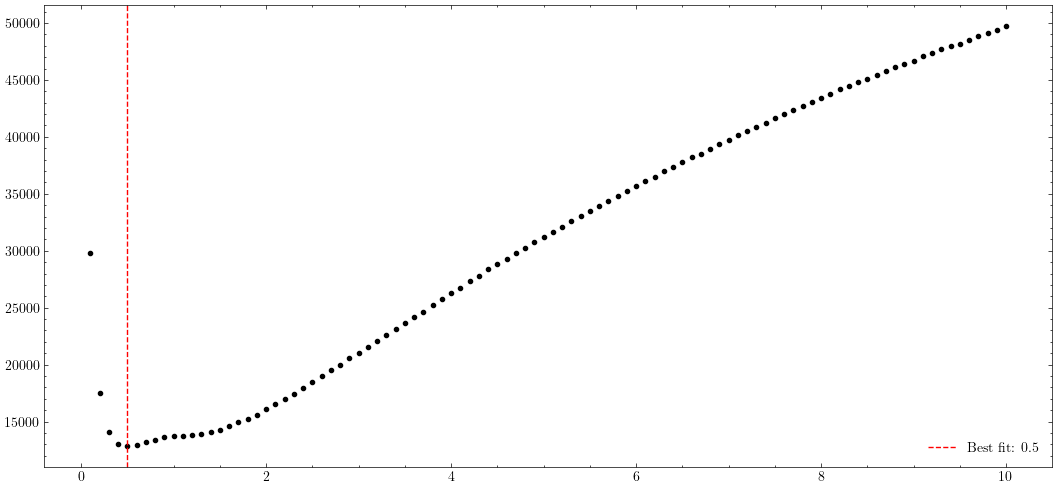

In [16]:
plt.figure(figsize=(13, 6))
plt.plot(qChi2.keys(), qChi2.values(), marker='.', color='black', linestyle='none')
plt.axvline(best_q, linestyle='--', color='r', label=f'Best fit: {best_q}')
plt.legend()
plt.show()

ParameterSet: 11 parameters
R  fitted_twigs@best_q_solutio...: ['teffratio@binary@orbit@component'
 'fillout_factor@contact_envelope@envelope@component'
 'incl@binary@orbit@component']
   adopt_parameters@best_q_sol...: ['teffratio@binary@orbit@component', 'fillout_factor@contact_envelope@envelope@component', 'incl@binary@orbit@component']
   adopt_distributions@best_q_...: False
   adopt_values@best_q_solutio...: True
R  message@best_q_solution@sol...: Optimization terminated successfully.
R  niter@best_q_solution@solution: 137
R  success@best_q_solution@sol...: True
R  initial_values@best_q_solut...: [1.1523282715905605 0.6417897080770943 90.0]
R  fitted_values@best_q_soluti...: [1.113426592351409 0.4118834715826688 117.62260991072824]
R  fitted_units@best_q_solutio...: ['' '' 'deg']
   comments@best_q_solution@so...: 0.5
Adopted:
teffratio@binary@orbit@component 1.11343  
fillout_factor@contact_envelope@envelope@component 0.41188  
incl@binary@orbit@component 117.62261 deg 

Origina

100%|██████████| 119/119 [00:05<00:00, 20.36it/s]


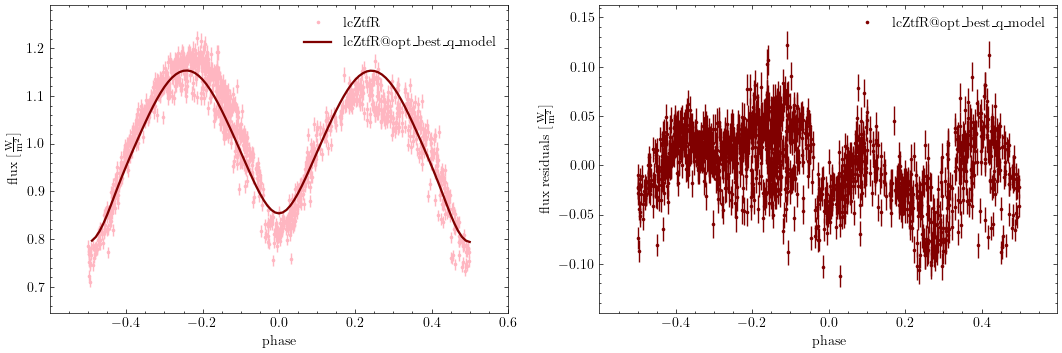

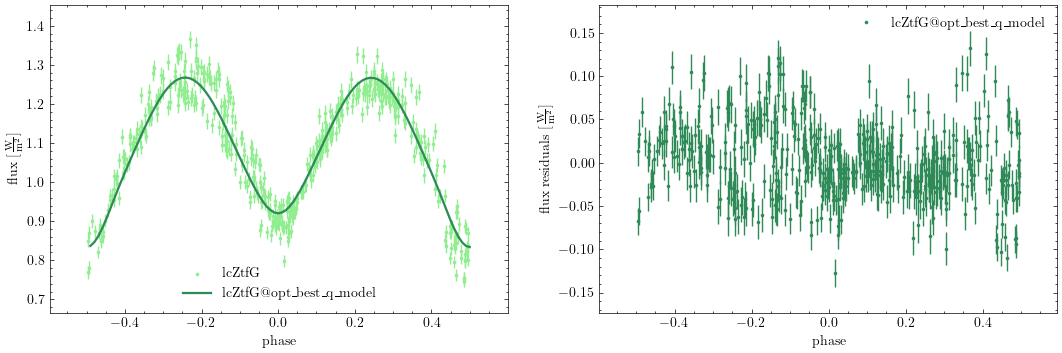

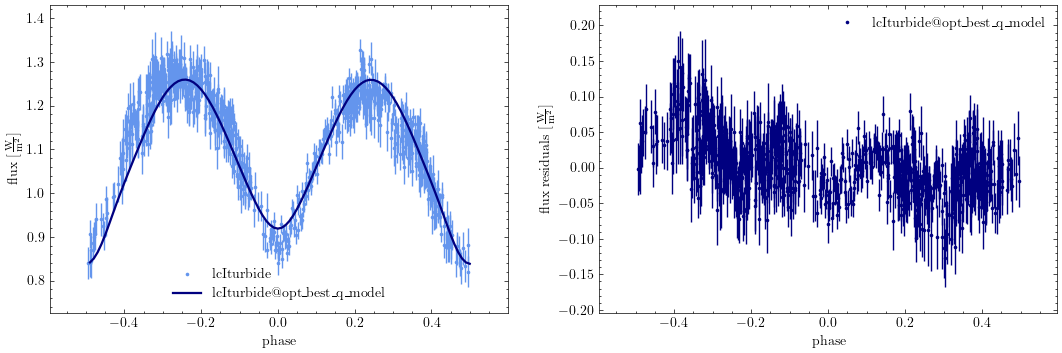

In [19]:
b.set_value(qualifier='q', value=0.5)
b.import_solution("./q-solutions/0.5000.sol", solution='best_q_solution', overwrite=True)
print(b['best_q_solution'])
_, computeModelName = opt_utils.adopt_solution(b, solution_name='best_q_solution')
gen_utils.plotModelResidualsFigsize(b, figsize=(13, 4), datasetGroups=allDatasets, model=computeModelName)

In [20]:
gen_utils.saveBundle(b, "best-fit", subfolder="q-search")

Thu, 13 Feb 2025 16:53 PARAMETERS   WARNING for faster compact saving, install ujson


'bundle-saves/q-search/best-fit.json.gz'